#### Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from config import awspassword

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import LabelEncoder

In [4]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import EasyEnsembleClassifier

In [5]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
##

In [6]:
import sqlalchemy 
import pandas

#### Import Dataset

In [7]:
#### DB Connection configuration
username = "postgres"
password = awspassword
endpoint = "us-accident.cnnhjjyro1tm.us-east-1.rds.amazonaws.com"  # something like amazonaws.com:5432
dbname   = "US_Accident"

In [8]:
## Connect to Db
con = sqlalchemy.create_engine("postgresql://%s:%s@%s/%s" % (username, password, endpoint, dbname))

In [9]:
## Get Data
accident_df = pandas.read_sql("select * from clean_accident_data;", con)
#print(accident_df)

## How Severity the Accidents is ?

##### Data preprocessing

In [10]:
accident_df.head()

,index,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Street,Side,...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Year,Month,Day,Hour,Weekday,time_duration
0,714730,976504,2,2021-11-30 12:03:00,2021-11-30 14:35:28,40.017779,-79.588926,0.019,E Crawford Ave,L,...,False,False,False,Day,2021,Nov,30,12,Tue,152.0
1,714731,976505,2,2021-11-09 03:40:42,2021-11-09 04:58:09,40.358217,-75.481838,0.016,W Campbell Rd,R,...,False,False,False,Night,2021,Nov,9,3,Tue,77.0
2,714732,976506,2,2021-06-15 13:04:20,2021-06-15 15:11:07,34.752959,-92.358407,0.026,W Markham St,L,...,False,False,False,Day,2021,Jun,15,13,Tue,127.0
3,714733,976507,2,2021-05-08 11:23:22,2021-05-08 13:30:34,34.752616,-92.350012,0.028,W Markham St,R,...,False,False,False,Day,2021,May,8,11,Sat,127.0
4,714734,976508,2,2021-05-03 10:23:00,2021-05-03 11:42:33,39.143345,-121.911514,0.127,Central St,L,...,False,False,False,Day,2021,May,3,10,Mon,80.0


In [11]:
print(accident_df.columns)

Index(['index', 'ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Street', 'Side', 'City', 'County',
       'State', 'Zipcode', 'Timezone', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Year', 'Month', 'Day', 'Hour',
       'Weekday', 'time_duration'],
      dtype='object')


In [12]:
#drop the non-beneficial columns
#accident_df=accident_df.drop(columns=['ID','End_Time','End_Lat','End_Lng','Description','Side','Airport_Code','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight',"Start_Time",'ID','Weather_Timestamp','Zipcode','Street','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Country'])
accident_df=accident_df.drop(columns=['index','ID','Zipcode','Start_Time','End_Time','Street'])

##reaso for droping columns
#ID: since they don't carry any information for the severity
#Start_Time,End_Time :because it was decomposed by the time features added before (day, month, weekday,Year)
#Zipcode :because we just focus on the City,County,state where the accident happened
#when considering whole dataset street column is too noisy ,so desided to drop it

##### Feature selection

In [13]:
#In the process of feature selection,in order to select best features from which our model can learn
#Observations from mock accedent datset ,feature by their importency Balance Random forest classifier we can drop least 5 impotence features:
# No_Exit,Traffic_Calming,Bump,Turning_Loop,Roundabout

In [14]:
accident_df=accident_df.drop(columns=['No_Exit','Traffic_Calming','Roundabout','Bump','Turning_Loop'])


In [15]:
accident_df.shape

(2207325, 33)

In [16]:
accident_df.dtypes

Severity               int64
Start_Lat            float64
Start_Lng            float64
Distance(mi)         float64
Side                  object
City                  object
County                object
State                 object
Timezone              object
Temperature(F)       float64
Wind_Chill(F)        float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction        object
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition     object
Amenity                 bool
Crossing                bool
Give_Way                bool
Junction                bool
Railway                 bool
Station                 bool
Stop                    bool
Traffic_Signal          bool
Sunrise_Sunset        object
Year                   int64
Month                 object
Day                    int64
Hour                   int64
Weekday               object
time_duration        float64
dtype: object

In [17]:
# Determine the number of unique values in each column.
accident_df.nunique()

Severity                  4
Start_Lat            887472
Start_Lng            904688
Distance(mi)          12753
Side                      2
City                   9723
County                 1541
State                    49
Timezone                  4
Temperature(F)          324
Wind_Chill(F)           708
Humidity(%)             100
Pressure(in)           1007
Visibility(mi)           55
Wind_Direction           23
Wind_Speed(mph)         103
Precipitation(in)       207
Weather_Condition       114
Amenity                   2
Crossing                  2
Give_Way                  2
Junction                  2
Railway                   2
Station                   2
Stop                      2
Traffic_Signal            2
Sunrise_Sunset            2
Year                      6
Month                    12
Day                      31
Hour                     24
Weekday                   7
time_duration          5235
dtype: int64

In [18]:
accident_df=accident_df.drop(columns=[])

In [19]:
accident_df=accident_df.dropna()

In [20]:
# accident_df.to_csv('C:/Users/Helanga/Desktop/THe_Final_Project_Data_Visualization/DataFile/mock_accident_Cleaneddata.csv', sep=',',encoding='utf-8',header='true')

In [21]:
#replace all bollean values to integer
accident_df.replace({False: 0, True: 1}, inplace=True)

In [22]:
accident_df.dtypes

Severity               int64
Start_Lat            float64
Start_Lng            float64
Distance(mi)         float64
Side                  object
City                  object
County                object
State                 object
Timezone              object
Temperature(F)       float64
Wind_Chill(F)        float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction        object
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition     object
Amenity                int64
Crossing               int64
Give_Way               int64
Junction               int64
Railway                int64
Station                int64
Stop                   int64
Traffic_Signal         int64
Sunrise_Sunset        object
Year                   int64
Month                 object
Day                    int64
Hour                   int64
Weekday               object
time_duration        float64
dtype: object

In [23]:
#Severity of the accident is our target
# check Severity column
accident_df['Severity'].value_counts()

2    2057075
3      64588
4      62106
1      23556
Name: Severity, dtype: int64

#### converting the string values into numerical ones using label encoder

In [24]:
# To see which columns have categorical value columns
X_cat = accident_df.select_dtypes(include='object').columns
X_cat

Index(['Side', 'City', 'County', 'State', 'Timezone', 'Wind_Direction',
       'Weather_Condition', 'Sunrise_Sunset', 'Month', 'Weekday'],
      dtype='object')

In [25]:
# examine all the catogorical columns
for column in accident_df[X_cat]:
    print(column,"\n", accident_df[column].value_counts())
    print("--------------------------------------")

Side 
 R    1791597
L     415728
Name: Side, dtype: int64
--------------------------------------
City 
 Miami            97723
Los Angeles      56471
Orlando          49691
Dallas           33052
Houston          28385
                 ...  
Miromar Lakes        1
Bridport             1
Polo                 1
Patten               1
Mescalero            1
Name: City, Length: 9723, dtype: int64
--------------------------------------
County 
 Los Angeles       163524
Miami-Dade        132288
Orange             98805
San Bernardino     44840
San Diego          38620
                   ...  
La Salle               1
Burnett                1
Ferry                  1
Macoupin               1
Norfolk City           1
Name: County, Length: 1541, dtype: int64
--------------------------------------
State 
 CA    604477
FL    350204
TX    108714
OR     98754
VA     92191
PA     87882
MN     84652
NY     84591
SC     81962
NC     73930
TN     45813
LA     43587
MD     42112
AZ     40965
NJ     3928

#### converting the string values into numerical ones using label encoder

In [26]:
from sklearn.preprocessing import LabelEncoder
#
# Instantiate LabelEncoder
#
le = LabelEncoder()


In [27]:
# Encode single column Side
#
accident_df.Side = le.fit_transform(accident_df.Side)
#
# Print df.head for checking the transformation

In [28]:
accident_df['Side']

0          0
1          1
2          0
3          1
4          0
          ..
2207320    1
2207321    1
2207322    1
2207323    0
2207324    1
Name: Side, Length: 2207325, dtype: int32

In [29]:
# Encode single column City
#
accident_df.City = le.fit_transform(accident_df.City)
#
# Print df.head for checking the transformation

In [30]:
accident_df['City']

0          1784
1          3460
2          4865
3          4865
4          5452
           ... 
2207320    1087
2207321    1087
2207322    6136
2207323    6136
2207324    6446
Name: City, Length: 2207325, dtype: int32

In [31]:
#accident_df['City'].unique().value_counts
print(accident_df['City'].nunique())

9723


In [32]:
# Encode single column County
#
accident_df.County = le.fit_transform(accident_df.County)
#
# Print df.head for checking the transformation

In [33]:
accident_df['County']

0           476
1           929
2          1128
3          1128
4          1345
           ... 
2207320     694
2207321     694
2207322     929
2207323     929
2207324    1016
Name: County, Length: 2207325, dtype: int32

In [34]:
print(accident_df['County'].nunique())

1541


In [35]:
# Encode single column State
#
accident_df.State = le.fit_transform(accident_df.State)
#
# Print df.head for checking the transformation

In [36]:
accident_df['State']

0          36
1          36
2           1
3           1
4           3
           ..
2207320    41
2207321    41
2207322    36
2207323    36
2207324     8
Name: State, Length: 2207325, dtype: int32

In [37]:
# Encode single column Timezone 
#
accident_df.Timezone  = le.fit_transform(accident_df.Timezone)
#
# Print df.head for checking the transformation

In [38]:
accident_df['Timezone']

0          1
1          1
2          0
3          0
4          3
          ..
2207320    0
2207321    0
2207322    1
2207323    1
2207324    1
Name: Timezone, Length: 2207325, dtype: int32

In [39]:
# Encode single column Wind_Direction 
#
accident_df.Wind_Direction  = le.fit_transform(accident_df.Wind_Direction)
#
# Print df.head for checking the transformation

In [40]:
accident_df['Wind_Direction']

0          15
1           0
2           6
3          14
4           8
           ..
2207320    13
2207321     1
2207322     6
2207323     9
2207324     7
Name: Wind_Direction, Length: 2207325, dtype: int32

In [41]:
# Encode single column Weather_Condition 
#
accident_df.Weather_Condition  = le.fit_transform(accident_df.Weather_Condition)
#
# Print df.head for checking the transformation

In [42]:
accident_df['Weather_Condition']

0          66
1          13
2          13
3          71
4          14
           ..
2207320    98
2207321    71
2207322     7
2207323    13
2207324    71
Name: Weather_Condition, Length: 2207325, dtype: int32

In [43]:
# Encode single column Sunrise_Sunset 
#
accident_df.Sunrise_Sunset  = le.fit_transform(accident_df.Sunrise_Sunset)
#
# Print df.head for checking the transformation

In [44]:
accident_df['Sunrise_Sunset']

0          0
1          1
2          0
3          0
4          0
          ..
2207320    0
2207321    0
2207322    0
2207323    0
2207324    0
Name: Sunrise_Sunset, Length: 2207325, dtype: int32

In [45]:
# Encode single column Day 
#
accident_df.Day  = le.fit_transform(accident_df.Day)
#
# Print df.head for checking the transformation

In [46]:
accident_df['Day']

0          29
1           8
2          14
3           7
4           2
           ..
2207320     0
2207321    17
2207322     4
2207323     6
2207324    27
Name: Day, Length: 2207325, dtype: int64

In [47]:
# Encode single column Day 
#
accident_df.Weekday  = le.fit_transform(accident_df.Weekday)
#
# Print df.head for checking the transformation

In [48]:
accident_df['Weekday']

0          5
1          5
2          5
3          2
4          1
          ..
2207320    3
2207321    0
2207322    5
2207323    3
2207324    5
Name: Weekday, Length: 2207325, dtype: int32

In [49]:
# Encode single column Day 
#
accident_df.Month  = le.fit_transform(accident_df.Month)
#
# Print df.head for checking the transformation

In [50]:
accident_df['Month']

0           9
1           9
2           6
3           8
4           8
           ..
2207320     1
2207321     6
2207322    10
2207323     7
2207324    11
Name: Month, Length: 2207325, dtype: int32

In [51]:
accident_df.dtypes

Severity               int64
Start_Lat            float64
Start_Lng            float64
Distance(mi)         float64
Side                   int32
City                   int32
County                 int32
State                  int32
Timezone               int32
Temperature(F)       float64
Wind_Chill(F)        float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction         int32
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition      int32
Amenity                int64
Crossing               int64
Give_Way               int64
Junction               int64
Railway                int64
Station                int64
Stop                   int64
Traffic_Signal         int64
Sunrise_Sunset         int32
Year                   int64
Month                  int32
Day                    int64
Hour                   int64
Weekday                int32
time_duration        float64
dtype: object

#### Split the Data into Training and Testing

In [52]:
# Create our features
X = accident_df.drop("Severity",axis=1) 
X.head()

,Start_Lat,Start_Lng,Distance(mi),Side,City,County,State,Timezone,Temperature(F),Wind_Chill(F),...,Station,Stop,Traffic_Signal,Sunrise_Sunset,Year,Month,Day,Hour,Weekday,time_duration
0,40.017779,-79.588926,0.019,0,1784,476,36,1,39.0,32.0,...,0,0,0,0,2021,9,29,12,5,152.0
1,40.358217,-75.481838,0.016,1,3460,929,36,1,36.0,36.0,...,0,0,0,1,2021,9,8,3,5,77.0
2,34.752959,-92.358407,0.026,0,4865,1128,1,0,90.0,90.0,...,0,0,0,0,2021,6,14,13,5,127.0
3,34.752616,-92.350012,0.028,1,4865,1128,1,0,77.0,77.0,...,0,0,0,0,2021,8,7,11,2,127.0
4,39.143345,-121.911514,0.127,0,5452,1345,3,3,73.0,73.0,...,0,0,0,0,2021,8,2,10,1,80.0


Even though Precipitation and Pressure have a small variance, there is no need to drop them since they usually have small increments.

In [53]:
#Create our target
y = accident_df['Severity']
y.value_counts()

2    2057075
3      64588
4      62106
1      23556
Name: Severity, dtype: int64

In [54]:
# examine shape of X

X.shape

(2207325, 32)

In [55]:
y.shape

(2207325,)

#### Split encoded Data into Training and Testing

In [56]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 1)

In [57]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [58]:
y_train.value_counts()

2    1542695
3      48586
4      46549
1      17663
Name: Severity, dtype: int64

#### Balanced Random Forest Classifier
Compared Balanced Random Forest Classifier with default parmeters and enhanced parameters to determine which gives   the best performance. 

#### Balanced Random Forest Classifier -with default parametars

In [59]:
# Resample the training data with the BalancedRandomForestClassifier

#model
brf_model = BalancedRandomForestClassifier(random_state=1, n_estimators=200)
#fit
brf_model = brf_model.fit(X_train, y_train)

#predict
predictions = brf_model.predict(X_test)

In [60]:
# Calculated the balanced accuracy score
RandomForest_accuracy = balanced_accuracy_score(y_test,predictions)
RandomForest_accuracy


0.8282682562848659

In [61]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1","Actual 2", "Actual 3"], columns=["Predicted 0", "Predicted 1","Predicted 2", "Predicted 3"])

cm_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,5536,0,315,42
Actual 1,8587,427222,22541,56030
Actual 2,1095,215,13235,1457
Actual 3,352,2003,2063,11139


In [62]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.36      0.94      0.98      0.52      0.96      0.92      5893
          2       0.99      0.83      0.94      0.91      0.88      0.77    514380
          3       0.35      0.83      0.95      0.49      0.89      0.78     16002
          4       0.16      0.72      0.89      0.26      0.80      0.63     15557

avg / total       0.95      0.83      0.94      0.87      0.88      0.77    551832



In [63]:
# We can sort the features by their importance.
sorted (zip(brf_model.feature_importances_,X.columns),reverse=True)

[(0.11871342712976353, 'time_duration'),
 (0.11801873136728051, 'Distance(mi)'),
 (0.10406652432262242, 'Year'),
 (0.08739942484772453, 'Start_Lng'),
 (0.08251959768728306, 'Start_Lat'),
 (0.0457665476029537, 'State'),
 (0.04271156787315825, 'Pressure(in)'),
 (0.03588971529393809, 'Month'),
 (0.033174105269417296, 'County'),
 (0.032379147772793875, 'City'),
 (0.031050259728677004, 'Humidity(%)'),
 (0.029338904150356372, 'Temperature(F)'),
 (0.0292852527026022, 'Wind_Chill(F)'),
 (0.0271898464186041, 'Hour'),
 (0.025096877005376366, 'Day'),
 (0.022700351189995093, 'Timezone'),
 (0.02103228756758055, 'Wind_Speed(mph)'),
 (0.020339081415260942, 'Wind_Direction'),
 (0.016267140566087936, 'Weekday'),
 (0.014934929316676207, 'Traffic_Signal'),
 (0.014488501000175713, 'Weather_Condition'),
 (0.011210567113317213, 'Crossing'),
 (0.008252669305536095, 'Side'),
 (0.008087976587139223, 'Visibility(mi)'),
 (0.006733038609766684, 'Sunrise_Sunset'),
 (0.005053446762918434, 'Junction'),
 (0.004763632

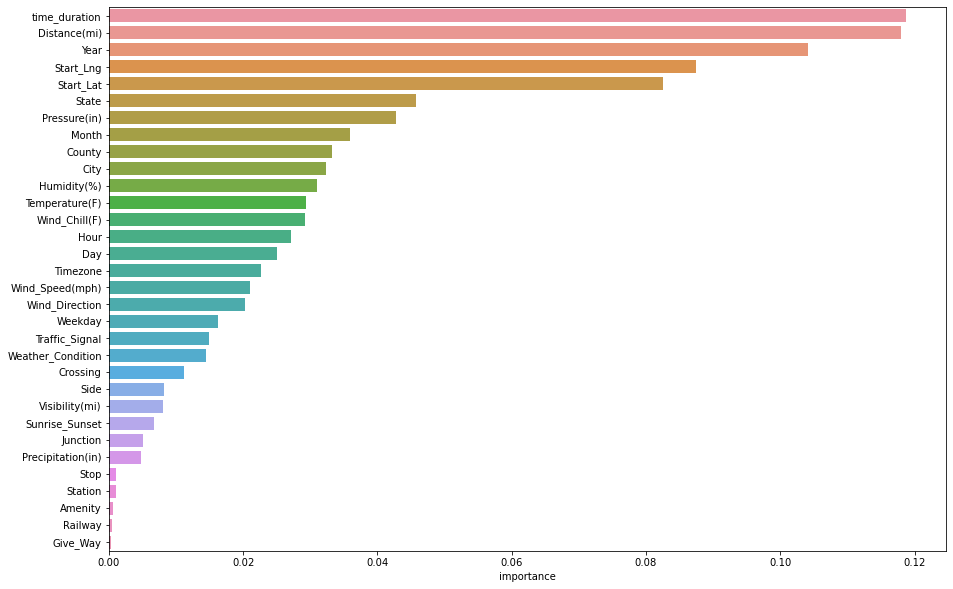

In [64]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = brf_model.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:40]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

#### Improving Random Forest Classifier
increase the number of trees to 1000 (n_estimators=1000)

In [65]:
# Resample the training data with the BalancedRandomForestClassifier

#model
brf_model = BalancedRandomForestClassifier(random_state=1, n_estimators=1000)
#fit
brf_model = brf_model.fit(X_train, y_train)

#predict
predictions = brf_model.predict(X_test)

In [66]:
# Calculated the balanced accuracy score
RandomForest_accuracy_improved = balanced_accuracy_score(y_test,predictions)
RandomForest_accuracy_improved

0.829602052258881

In [67]:
# Report

accuracy=[(RandomForest_accuracy*100),(RandomForest_accuracy_improved*100)]

    
df = {'RFC Default/Improved': ['with 100 n_estimators','with 1000 n_estimators'], \
      'Acuuracy_Score':accuracy}

Report = pd.DataFrame(data=df, columns=['RFC Default/Improved','Acuuracy_Score'], index=None)
Report

,RFC Default/Improved,Acuuracy_Score
0,with 100 n_estimators,82.826826
1,with 1000 n_estimators,82.960205
